In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# UCSD

In [2]:
import utils

ucsd_data = utils.Dataset("ucsd", multi_class=True)

In [ ]:
eoc_question_cols = [c for c in ucsd_data.feature_cols if c.endswith("_q")]

In [ ]:
ucsd_data.data[eoc_question_cols + ["label"]]

,ch01_q,ch02_q,ch03_q,ch04_q,ch05_q,ch06_q,ch07_q,ch08_q,ch09_q,ch10_q,ch11_q,ch12_q,label
0,0.785714,0.470588,0.888889,0.222222,0.666667,0.421053,0.55,0.444444,0.0,0.0,0.0,0.0,0
1,1.000000,0.647059,0.777778,0.444444,0.611111,0.421053,0.45,0.333333,0.0,0.0,0.0,0.0,0
2,0.785714,0.882353,0.888889,0.944444,0.833333,0.842105,0.65,0.833333,0.0,0.0,0.0,0.0,0
3,0.785714,0.764706,0.722222,0.666667,0.611111,0.473684,0.50,0.388889,0.0,0.0,0.0,0.0,1
4,0.642857,0.941176,0.833333,0.111111,0.111111,0.368421,0.50,0.166667,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,0.571429,0.588235,0.500000,0.611111,0.333333,0.526316,0.65,0.388889,0.0,0.0,0.0,0.0,2
179,0.714286,0.764706,0.666667,0.666667,0.611111,0.473684,0.20,0.111111,0.0,0.0,0.0,0.0,1
180,0.714286,0.647059,0.611111,0.611111,0.555556,0.526316,0.60,0.555556,0.0,0.0,0.0,0.0,0
181,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,2


In [26]:
def calculate_running_averages(df):
    """
    Calculate running averages for chapter scores, including 0.0 values.

    Args:
        df (pd.DataFrame): Input dataframe containing chapter question scores (ch##_q columns)

    Returns:
        pd.DataFrame: DataFrame with only prediction columns (ch##_pred) and label column
    """
    df = df.copy()  # Create a copy to avoid modifying the original dataframe

    # Calculate prediction columns based on running averages
    pred_cols = []  # Keep track of prediction columns
    for i in range(1, 9):
        # Get all question columns up to chapter i
        cols_to_avg = [f"ch{str(j).zfill(2)}_q" for j in range(1, i + 1)]
        pred_col = f"ch{str(i).zfill(2)}_pred"
        pred_cols.append(pred_col)
        # Calculate mean across selected columns, including 0.0 values
        df[pred_col] = df[cols_to_avg].mean(axis=1)

    # Return only prediction columns and label
    return df[pred_cols + ["label"]]

In [ ]:
ucsd_baseline_predictions = calculate_running_averages(ucsd_data.data)
ucsd_baseline_predictions

,ch01_pred,ch02_pred,ch03_pred,ch04_pred,ch05_pred,ch06_pred,ch07_pred,ch08_pred,label
0,0.785714,0.628151,0.715064,0.591853,0.606816,0.575855,0.572162,0.556197,0
1,1.000000,0.823529,0.808279,0.717320,0.696078,0.650241,0.621635,0.585597,0
2,0.785714,0.834034,0.852319,0.875350,0.866947,0.862807,0.832406,0.832522,0
3,0.785714,0.775210,0.757547,0.734827,0.710084,0.670684,0.646301,0.614124,1
4,0.642857,0.792017,0.805789,0.632120,0.527918,0.501335,0.501144,0.459335,1
...,...,...,...,...,...,...,...,...,...
178,0.571429,0.579832,0.553221,0.567694,0.520822,0.521737,0.540061,0.521164,2
179,0.714286,0.739496,0.715219,0.703081,0.684687,0.649520,0.585303,0.526029,1
180,0.714286,0.680672,0.657485,0.645892,0.627824,0.610906,0.609348,0.602624,0
181,1.000000,0.500000,0.333333,0.250000,0.200000,0.166667,0.142857,0.125000,2


In [57]:
import pandas as pd


def evaluate_chapter_accuracy(predictions_df):
    """
    Evaluate prediction accuracy for each chapter based on thresholds:
    >= 0.9: class 0 (high performing)
    >= 0.8: class 1 (medium performing)
    < 0.8:  class 2 (low performing)
    Chapters 9-12 use the same predictions as chapter 8 for consistency.

    Args:
        predictions_df (pd.DataFrame): DataFrame containing chapter predictions and true labels

    Returns:
        pd.DataFrame: DataFrame with accuracy for each chapter (1 row, 12 columns)
    """
    accuracies = {}

    # For each chapter
    for i in range(1, 13):
        # Use chapter 8's predictions for chapters 9-12
        source_chapter = min(i, 8)
        source_col = f"ch{str(source_chapter).zfill(2)}_pred"
        pred_col = f"ch{str(i).zfill(2)}_pred"

        # Convert predictions to class labels based on thresholds
        predicted_labels = predictions_df[source_col].apply(
            lambda x: 0 if x >= 0.9 else (1 if x >= 0.8 else 2)
        )

        # Calculate accuracy
        accuracy = (predicted_labels == predictions_df["label"]).mean()
        accuracies[pred_col.replace("_pred", "_accuracy")] = accuracy

    # Create a single-row DataFrame with accuracies
    return pd.DataFrame([accuracies])

In [58]:
ucsd_baseline_accuracies = evaluate_chapter_accuracy(ucsd_baseline_predictions)
ucsd_baseline_accuracies

,ch01_accuracy,ch02_accuracy,ch03_accuracy,ch04_accuracy,ch05_accuracy,ch06_accuracy,ch07_accuracy,ch08_accuracy,ch09_accuracy,ch10_accuracy,ch11_accuracy,ch12_accuracy
0,0.338798,0.306011,0.300546,0.311475,0.295082,0.289617,0.26776,0.262295,0.262295,0.262295,0.262295,0.262295


# UCSD -> UCLA

This is not a trained model, so the result is equivalent to compute the UCLA accuracies directly.







In [59]:
ucla_data = utils.Dataset("ucla_session_a", multi_class=True)
ucla_baseline_predictions = calculate_running_averages(ucla_data.data)
ucla_baseline_predictions.head()

,ch01_pred,ch02_pred,ch03_pred,ch04_pred,ch05_pred,ch06_pred,ch07_pred,ch08_pred,label
0,0.928571,0.876050,0.861811,0.826914,0.817087,0.786169,0.773859,0.677127,0
1,0.785714,0.804622,0.610489,0.568978,0.521849,0.461190,0.452448,0.423670,0
2,0.785714,0.657563,0.679116,0.689893,0.651914,0.604665,0.603999,0.590999,0
3,0.857143,0.869748,0.876128,0.907096,0.925677,0.929292,0.917965,0.907386,1
4,0.928571,0.964286,0.920635,0.690476,0.719048,0.713241,0.697064,0.686320,1


In [ ]:
ucla_baseline_accuracies = evaluate_chapter_accuracy(ucla_baseline_predictions)
ucla_baseline_accuracies

,ch01_accuracy,ch02_accuracy,ch03_accuracy,ch04_accuracy,ch05_accuracy,ch06_accuracy,ch07_accuracy,ch08_accuracy,ch09_accuracy,ch10_accuracy,ch11_accuracy,ch12_accuracy
0,0.416667,0.333333,0.316667,0.283333,0.266667,0.2,0.2,0.25,0.25,0.25,0.25,0.25


# Compare

In [61]:
ucsd_metrics = pd.read_csv("metrics/ucsd_metrics_finetune.csv")
ucsd_metrics.head(20)

,Class2_PR_AUC,Precision,F1,Accuracy,Recall,PR_AUC,Class2_ROC_AUC,Class2_F1,ROC_AUC,Class2_Recall,Class2_Precision,Model,Chapter,Trial
0,0.292351,0.220112,0.176106,0.278228,0.278228,0.522350,0.520722,0.345542,0.522780,0.850000,0.219460,Original,1,1
1,0.348390,0.332112,0.310634,0.376276,0.376276,0.587007,0.538634,0.377866,0.589970,0.777778,0.258275,Original,2,1
2,0.351472,0.447983,0.408830,0.469820,0.469820,0.592922,0.551970,0.394404,0.614705,0.702778,0.297304,Original,3,1
3,0.354860,0.442870,0.417823,0.480931,0.480931,0.602103,0.583238,0.345058,0.621312,0.608333,0.268506,Original,4,1
4,0.330067,0.531145,0.498796,0.552553,0.552553,0.604516,0.540685,0.320196,0.616519,0.513889,0.273810,Original,5,1
5,0.288438,0.531228,0.509601,0.574775,0.574775,0.584977,0.498864,0.327521,0.599717,0.469444,0.415462,Original,6,1
6,0.283180,0.518222,0.499453,0.552553,0.552553,0.575620,0.513100,0.266577,0.581561,0.352778,0.374286,Original,7,1
7,0.514868,0.627957,0.609436,0.640541,0.640541,0.661315,0.690849,0.472222,0.682631,0.563889,0.467692,Original,8,1
8,0.702274,0.728174,0.692900,0.710961,0.710961,0.785219,0.842944,0.591377,0.805948,0.666667,0.600711,Original,9,1
9,0.719446,0.671091,0.673975,0.688889,0.688889,0.805945,0.855408,0.555407,0.837712,0.641667,0.493823,Original,10,1


In [ ]:
# group by model and chapter, take the mean of the accuracy column
ucsd_metrics = (
    ucsd_metrics.groupby(["Model", "Chapter"])["Accuracy"].mean().reset_index()
)
ucsd_metrics.head(20)

,Model,Chapter,Accuracy
0,Augmented,1,0.567327
1,Augmented,2,0.645135
2,Augmented,3,0.658078
3,Augmented,4,0.678829
4,Augmented,5,0.685315
5,Augmented,6,0.701622
6,Augmented,7,0.704925
7,Augmented,8,0.709309
8,Augmented,9,0.712643
9,Augmented,10,0.714775


In [63]:
baseline_df = ucsd_baseline_accuracies.melt(var_name="Chapter", value_name="Accuracy")

# Add Model column and clean up Chapter column
baseline_df["Model"] = "Baseline"
baseline_df["Chapter"] = baseline_df["Chapter"].str.extract("(\d+)").astype(int)

# Combine with existing metrics DataFrame
combined_df = pd.concat(
    [baseline_df[["Model", "Chapter", "Accuracy"]], ucsd_metrics]
).reset_index(drop=True)

In [ ]:
combined_df

,Model,Chapter,Accuracy
0,Baseline,1,0.338798
1,Baseline,2,0.306011
2,Baseline,3,0.300546
3,Baseline,4,0.311475
4,Baseline,5,0.295082
...,...,...,...
67,Sequence Augmented,8,0.697237
68,Sequence Augmented,9,0.723423
69,Sequence Augmented,10,0.733393
70,Sequence Augmented,11,0.734324


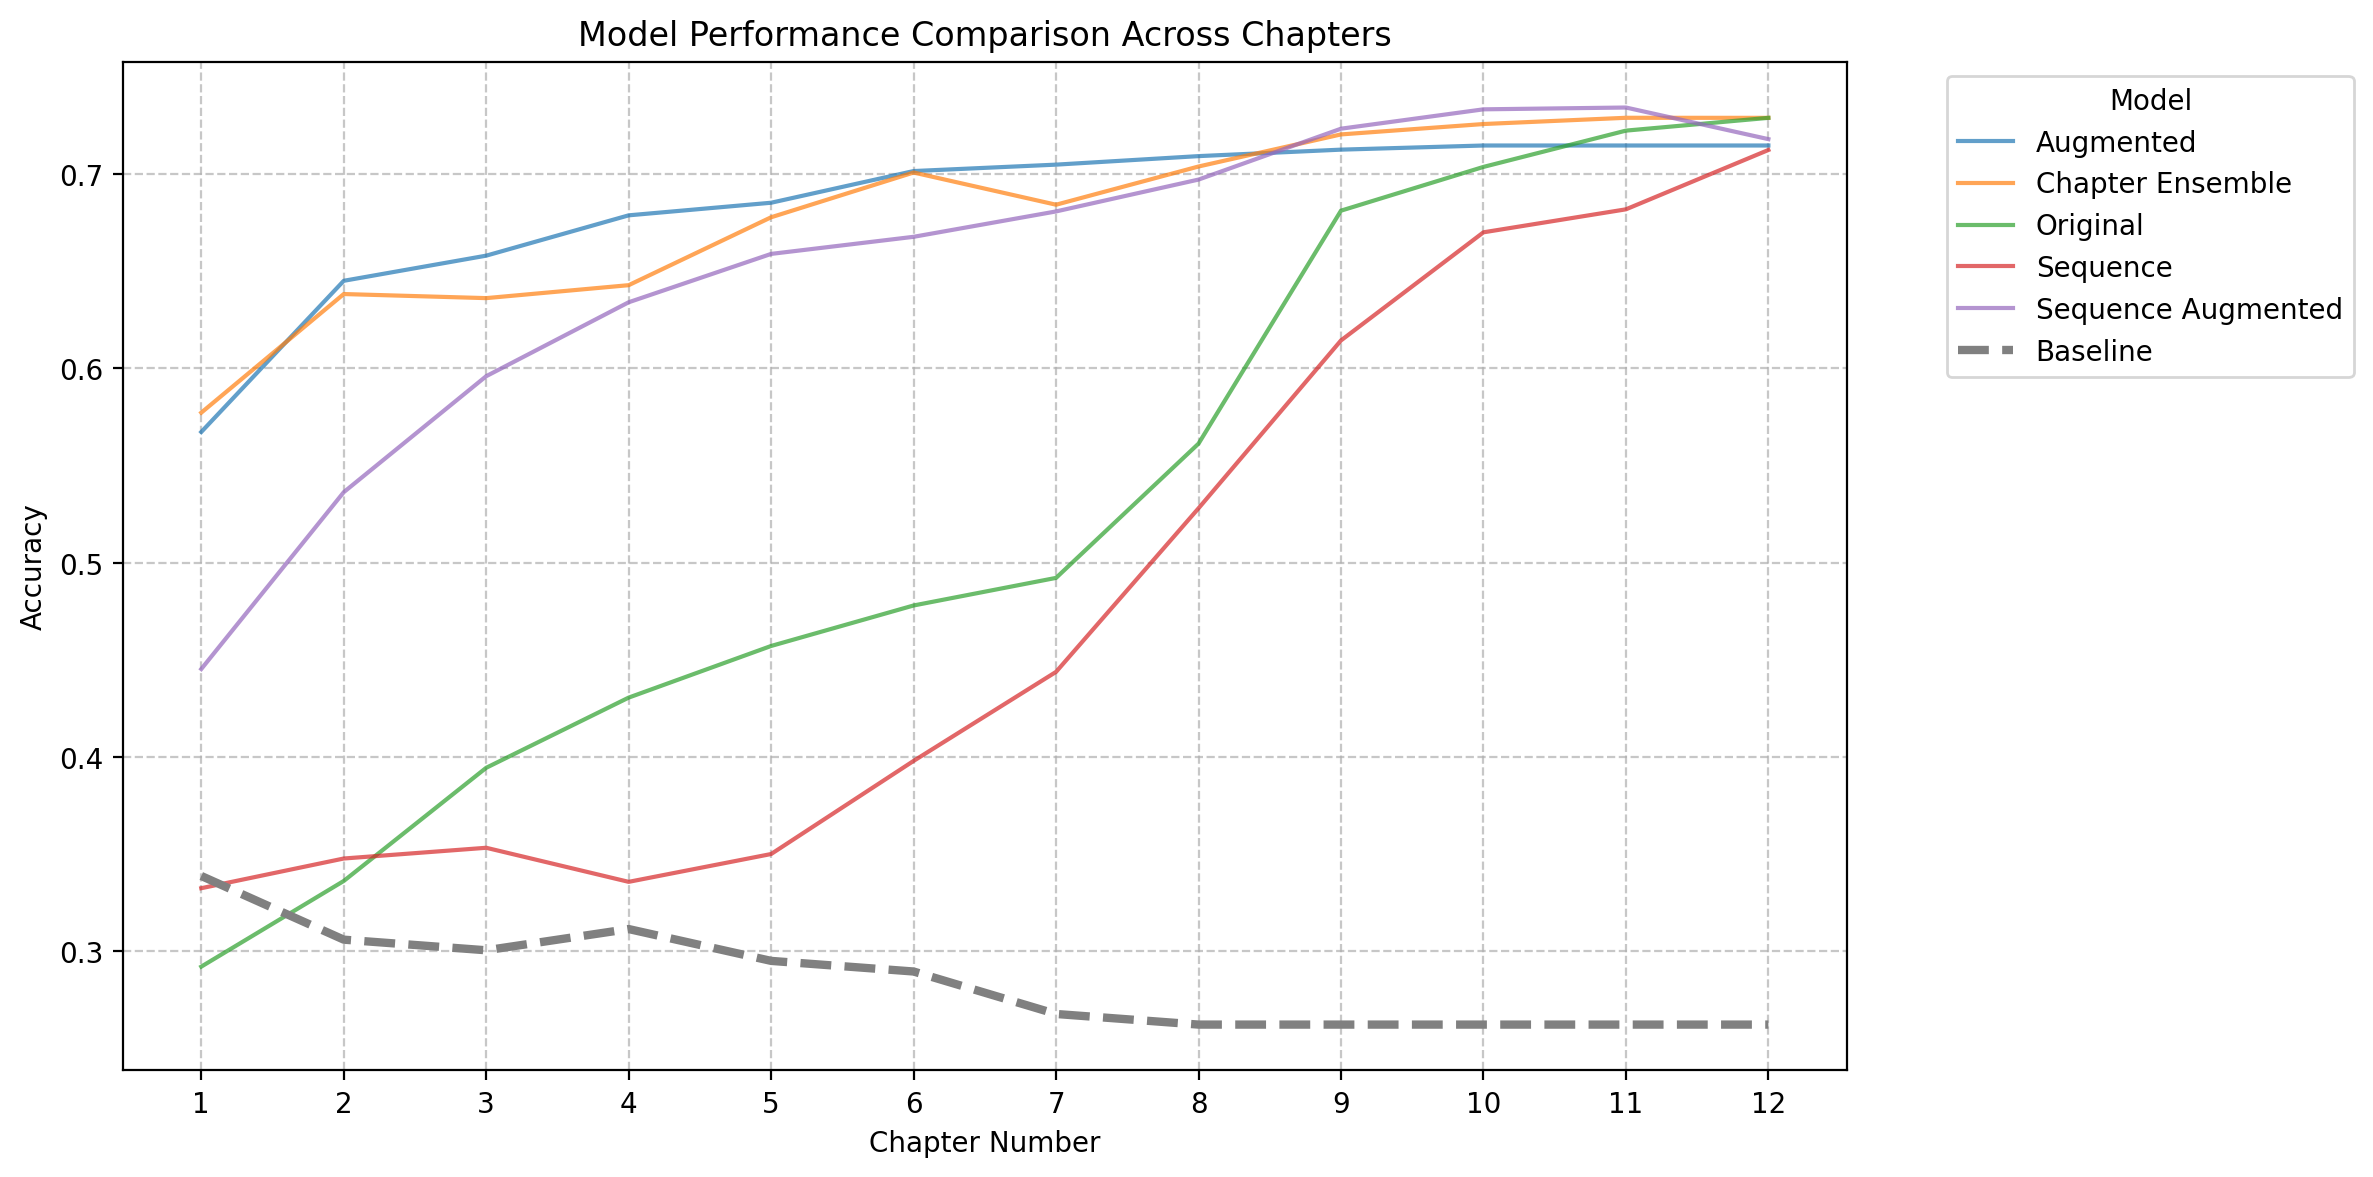

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(12, 6))

# Plot non-baseline models first
sns.lineplot(
    data=combined_df[combined_df["Model"] != "Baseline"],
    x="Chapter",
    y="Accuracy",
    hue="Model",
    alpha=0.7,
)

# Plot baseline with dark grey dashed line
sns.lineplot(
    data=combined_df[combined_df["Model"] == "Baseline"],
    x="Chapter",
    y="Accuracy",
    label="Baseline",
    color="grey",  # dark grey
    linewidth=3,
    linestyle="--",
)

# Customize the plot
plt.title("Model Performance Comparison Across Chapters")
plt.xlabel("Chapter Number")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.7)

# Adjust legend
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust x-axis ticks to show all chapters
plt.xticks(range(1, 13))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot if needed
plt.savefig("model_comparison.png", bbox_inches="tight", dpi=300)

plt.show()